In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import multiprocessing as mp
from datetime import datetime
import traceback
import sys
sys.path.insert(0, '../../data/siim-pneumothorax')

import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai
from fastai.vision import *
from mask_functions import *
from fastai.callbacks import SaveModelCallback
import gc
from sklearn.model_selection import KFold
from PIL import Image

fastai.__version__


'1.0.54'

In [2]:
sz = 512
bs = 2
n_acc = 64//bs #gradinet accumulation steps
nfolds = 4
SEED = 2019

data_path = '../../data/siim-pneumothorax'
torch.cuda.set_device('cuda:1')
os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

TRAIN = os.path.join(data_path, 'train_{}'.format(sz))
TEST = os.path.join(data_path, 'test_{}'.format(sz))
MASKS = os.path.join(data_path, 'masks_{}'.format(sz))

if sz == 256:
    stats = ([0.540,0.540,0.540],[0.264,0.264,0.264])
elif sz == 512:
    stats = ([0.529,0.529,0.529],[0.259,0.259,0.259])
elif sz == 768:
    stats = ([0.525,0.525,0.525],[0.256,0.256,0.256])
elif sz == 1024:
    stats = ([0.521,0.521,0.521],[0.254,0.254,0.254])
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)


In [3]:
class gpu_mem_restore_ctx():
    " context manager to reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    def __enter__(self): return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        if not exc_val: return True
        traceback.clear_frames(exc_tb)
        raise exc_type(exc_val).with_traceback(exc_tb) from None

In [4]:
from fastai.vision.learner import create_head, cnn_config, num_features_model, create_head
from fastai.callbacks.hooks import model_sizes, hook_outputs, dummy_eval, Hook, _hook_inner
from fastai.vision.models.unet import _get_sfs_idxs, UnetBlock

class Hcolumns(nn.Module):
    def __init__(self, hooks:Collection[Hook], nc:Collection[int]=None):
        super(Hcolumns,self).__init__()
        self.hooks = hooks
        self.n = len(self.hooks)
        self.factorization = None 
        if nc is not None:
            self.factorization = nn.ModuleList()
            for i in range(self.n):
                self.factorization.append(nn.Sequential(
                    conv2d(nc[i],nc[-1],3,padding=1,bias=True),
                    conv2d(nc[-1],nc[-1],3,padding=1,bias=True)))
                #self.factorization.append(conv2d(nc[i],nc[-1],3,padding=1,bias=True))
        
    def forward(self, x:Tensor):
        n = len(self.hooks)
        out = [F.interpolate(self.hooks[i].stored if self.factorization is None
            else self.factorization[i](self.hooks[i].stored), scale_factor=2**(self.n-i),
            mode='bilinear',align_corners=False) for i in range(self.n)] + [x]
        return torch.cat(out, dim=1)

class DynamicUnet_Hcolumns(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, blur:bool=False, blur_final=True, 
                 self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        self.hc_hooks = [Hook(layers[-1], _hook_inner, detach=False)]
        hc_c = [x.shape[1]]
        
        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, 
                blur=blur, self_attention=sa, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)
            self.hc_hooks.append(Hook(layers[-1], _hook_inner, detach=False))
            hc_c.append(x.shape[1])

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        hc_c.append(ni)
        layers.append(Hcolumns(self.hc_hooks, hc_c))
        layers += [conv_layer(ni*len(hc_c), n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
        norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, 
        blur:bool=False, self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, 
        last_cross:bool=True, bottle:bool=False, cut:Union[int,Callable]=None, 
        hypercolumns=True, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    M = DynamicUnet_Hcolumns if hypercolumns else DynamicUnet
    model = to_device(M(body, n_classes=data.c, blur=blur, blur_final=blur_final,
        self_attention=self_attention, y_range=y_range, norm_type=norm_type, 
        last_cross=last_cross, bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn


In [5]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [6]:
def set_BN_momentum(model,momentum=0.1*bs/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

In [7]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [8]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [9]:
def criterion_pixel(logit_pixel, truth_pixel):
    logit = torch.softmax(logit_pixel, dim=1)
    logit = logit.argmax(dim=1).view(-1).float()

    truth = truth_pixel.view(-1).float()

    assert(logit.shape==truth.shape)

    loss = F.binary_cross_entropy_with_logits(logit, truth, reduction='none')
    if 0:
        loss = loss.mean()
    if 1:
        pos = (truth>0.5).float()
        neg = (truth<0.5).float()
        pos_weight = pos.sum().item() + 1e-12
        neg_weight = neg.sum().item() + 1e-12
        loss = (0.25*pos*loss/pos_weight + 0.75*neg*loss/neg_weight).sum()

    return loss

In [10]:
def get_preds(learn, ds_type=DatasetType.Valid):
    preds = []
    ys = []
    
    model = learn.model
    model.eval()
    
    dl = learn.dl(ds_type)
    
    with torch.no_grad():
        for xb, yb in progress_bar(dl):
            pred = model(xb)
            pred = F.softmax(pred, dim=1)
            
            preds.append(to_detach(pred))
            ys.append(yb.cpu())
            
    del pred
    gc.collect()
    torch.cuda.empty_cache()
    
    return torch.cat(preds),torch.cat(ys)

In [11]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    # preds, ys = learn.get_preds(ds_type)
    preds, ys = get_preds(learn, ds_type)
    preds = preds[:,1,...]
    
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = get_preds(learn, ds_type)
    
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    
    del preds_lr
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return preds, ys

In [12]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

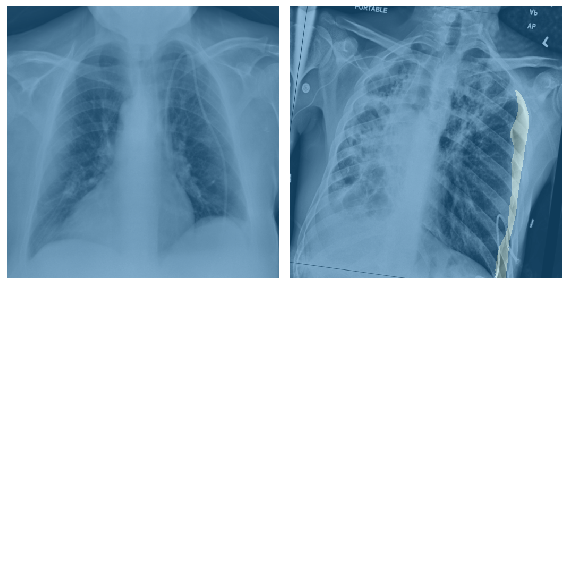

In [13]:
def get_data(fold):
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    valid_idx = list(kf.split(list(range(len(Path(TRAIN).ls())))))[fold][1]
    # Create databunch
    data = (SegmentationItemList.from_folder(TRAIN)
            .split_by_idx(valid_idx)
            .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0,1])
            .add_test(Path(TEST).ls(), label=None)
            .transform(get_transforms(), size=sz, tfm_y=True)
            .databunch(path=Path('.'), bs=bs)
            .normalize(stats))
    return data

# Display some images with masks
get_data(0).show_batch()

In [14]:
ids = [o.stem for o in get_data(0).test_ds.items]
id_df = pd.DataFrame({'ImageId': ids})

id_df.to_csv(os.path.join(data_path, 'test_ids.csv'), index=False)

## Training


In [14]:
scores, best_thrs = [],[]
now = datetime.now()

for fold in range(nfolds):
    print('fold: ', fold)
    data = get_data(fold)
    
    learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=True)
    
    learn.loss_func = criterion_pixel
    learn.clip_grad(1.0);
    set_BN_momentum(learn.model)
    
    #fit the decoder part of the model keeping the encode frozen
    lr = 1e-3
    learn.fit_one_cycle(6, lr, callbacks = [AccumulateStep(learn,n_acc)])
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(12, slice(lr/80, lr/2), callbacks=[AccumulateStep(learn,n_acc)])
    learn.save('hc_{}_{}_fold{}'.format(now.strftime('%Y%m%d-%H%M%S'), sz, fold));
    
    gc.collect()
    torch.cuda.empty_cache()

fold:  0


epoch,train_loss,valid_loss,dice,time


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## finetune

In [13]:
scores, best_thrs = [],[]
now = datetime.now()
tag = '20190718-105908_512'

for fold in range(nfolds):
    print('fold: ', fold)
    data = get_data(fold)
    
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.load('hc_{}_fold{}'.format(tag, fold))

    learn.clip_grad(1.0);
    set_BN_momentum(learn.model)
    
    lr = 1e-3
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(24, slice(lr/160, lr/4), callbacks=[AccumulateStep(learn,n_acc)])
    learn.save('hc_{}_{}_fold{}'.format(now.strftime('%Y%m%d-%H%M%S'), sz, fold));
    
    gc.collect()
    torch.cuda.empty_cache()

fold:  0


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,dice,time
0,0.003731,0.008705,0.834523,24:00
1,0.004231,0.008592,0.827340,23:55
2,0.005052,0.009378,0.834659,23:57
3,0.004840,0.010500,0.835235,23:57
4,0.004235,0.009067,0.827959,24:01
5,0.004485,0.009859,0.834304,24:00
6,0.004401,0.009162,0.827666,23:57
7,0.003619,0.010116,0.834231,23:58
8,0.004059,0.011846,0.829972,23:58
9,0.003933,0.010379,0.822674,23:56


fold:  1


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,dice,time
0,0.006272,0.008401,0.836677,23:50
1,0.005965,0.007991,0.837687,23:51
2,0.005742,0.008330,0.836402,23:54
3,0.004851,0.008660,0.836941,23:54
4,0.003717,0.009443,0.836189,23:54
5,0.003591,0.009373,0.835346,23:54
6,0.005402,0.008996,0.832550,23:56
7,0.003447,0.010477,0.834884,23:54
8,0.002824,0.010582,0.832034,23:57
9,0.004740,0.009257,0.828990,23:56


fold:  2


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,dice,time
0,0.005230,0.009304,0.831000,24:06
1,0.004459,0.008999,0.831164,24:10
2,0.004341,0.009293,0.827724,24:08
3,0.003950,0.010195,0.823967,24:09
4,0.003614,0.009334,0.826806,24:07
5,0.004579,0.009404,0.827298,24:08
6,0.004387,0.008848,0.827047,24:08
7,0.004340,0.009509,0.826618,24:07
8,0.004805,0.009804,0.817732,24:06
9,0.006010,0.010565,0.830331,24:05


fold:  3


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,dice,time
0,0.004906,0.008021,0.834110,24:04
1,0.005141,0.008440,0.832756,24:00
2,0.004684,0.008179,0.829751,24:01
3,0.004556,0.008070,0.827246,24:03
4,0.004602,0.009237,0.832391,24:02
5,0.004874,0.008936,0.829328,23:56
6,0.009148,0.009189,0.828634,24:00
7,0.005756,0.008534,0.835867,24:02
8,0.004985,0.009005,0.833584,24:03
9,0.003792,0.009921,0.833620,24:00


In [14]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())
print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

scores:  []
mean score:  nan
thresholds:  []
best threshold:  nan


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


In [ ]:
best_dice = dices.max()
plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thrs[-1], ymin=dices.min(), ymax=dices.max())
plt.text(best_thrs[-1]+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

In [ ]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

## Alternatively, let's load and pred  


In [13]:
tag = '20190729-122311_512'
scores, n_scores, best_thrs, best_nthrs = [], [], [], []

with gpu_mem_restore_ctx():
    for fold in range(nfolds):
        print('fold: ', fold)

        data = get_data(fold)

        # load pretrained model
        learn = unet_learner(data, models.resnet34, metrics=[dice])
        learn.load('hc_{}_fold{}'.format(tag, fold))

        #prediction on val and test sets
        preds, ys = pred_with_flip(learn)

        #remove noise
        preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0

        # boost body points

        #optimal threshold 
        #The best way would be collecting all oof predictions followed by a single threshold
        #calculation. However, it requres too much RAM for high image resolution
        dices = []
        thrs = np.arange(0.01, 1, 0.01)
        
        preds = preds.cpu()
        ys = ys.cpu()

        for th in progress_bar(thrs):
            preds_m = (preds>th).long()
            dices.append(dice_overall(preds_m, ys).mean())
        dices = np.array(dices)    
        scores.append(dices.max())
        best_thrs.append(thrs[dices.argmax()])
        
        # find best noise threshold
        n_dices = []
        n_thrs = np.arange(10, 101, 1)
        
        fold_best_thr = thrs[dices.argmax()]
        
        for n_thr in progress_bar(n_thrs):
            preds_n = (preds>fold_best_thr).long()
            preds_n[preds_n.view(preds_n.shape[0],-1).sum(-1) < n_thr*(sz/128.0)**2,...] = 0.0
            n_dices.append(dice_overall(preds_n, ys).mean())
        n_dices = np.array(n_dices)
        n_scores.append(n_dices.max())
        best_nthrs.append(n_thrs[n_dices.argmax()])

        # clean up
        if fold != nfolds-1: 
            del learn, data

        gc.collect()
        torch.cuda.empty_cache()


fold:  0


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  1


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  2


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  3


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
print('scores: ', scores)
print('mean score: ', np.array(scores).mean())
print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

scores:  [0.82918185, 0.82652014, 0.8215031, 0.82368755]
mean score:  0.82522315
thresholds:  [0.5800000000000001, 0.46, 0.56, 0.61]
best threshold:  0.5525


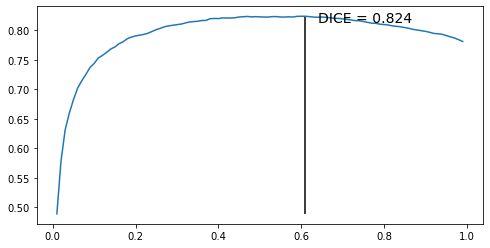

In [15]:
best_dice = dices.max()
plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thrs[-1], ymin=dices.min(), ymax=dices.max())
plt.text(best_thrs[-1]+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

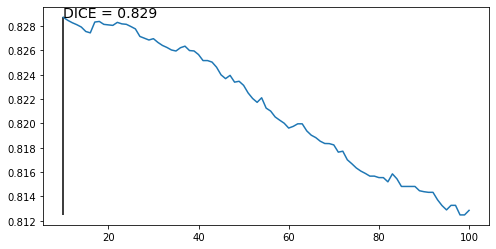

best_noise_dice: 0.8287045359611511 @ thr: 10


In [16]:
best_ndice = n_dices.max()
best_nthr = n_thrs[n_dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(n_thrs, n_dices)
plt.vlines(x=best_nthr, ymin=n_dices.min(), ymax=n_dices.max())
plt.text(best_nthr, best_ndice, f'DICE = {best_ndice:.3f}', fontsize=14);
plt.show()

print('best_noise_dice: {} @ thr: {}'.format(best_ndice, best_nthr))

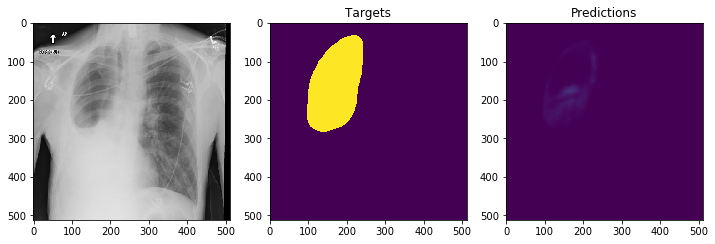

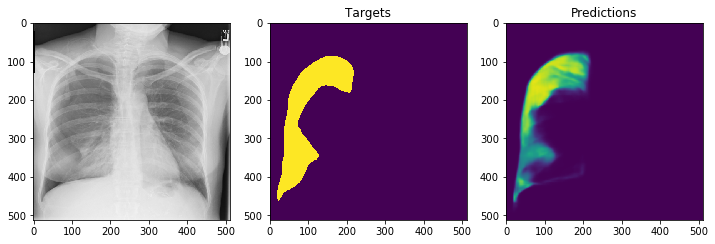

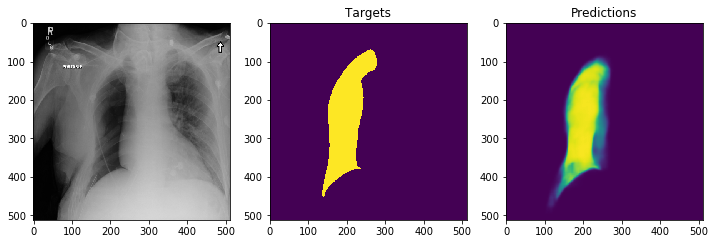

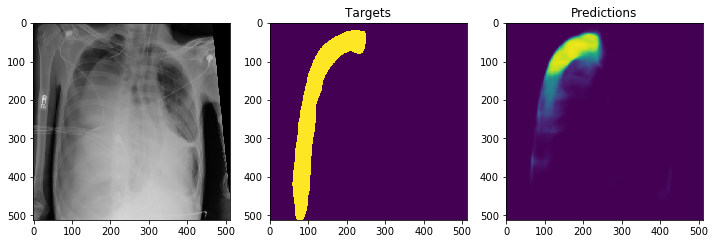

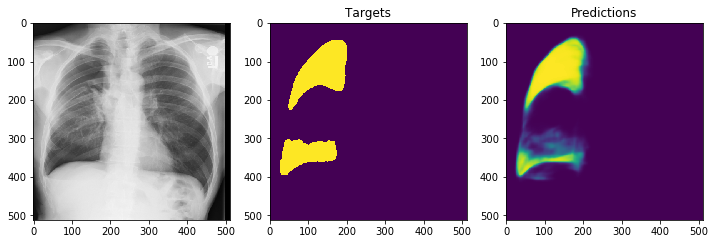

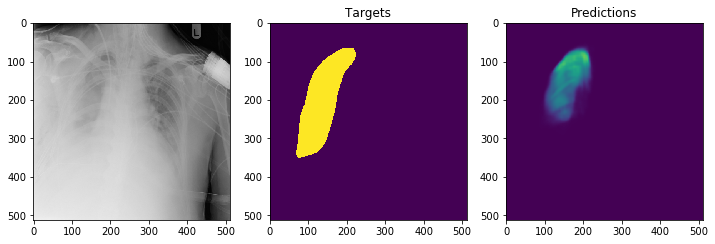

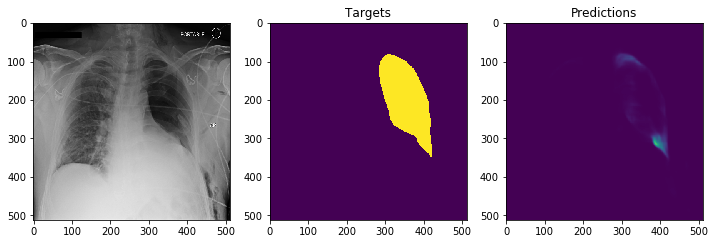

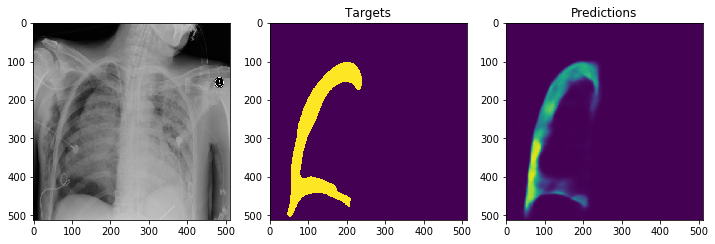

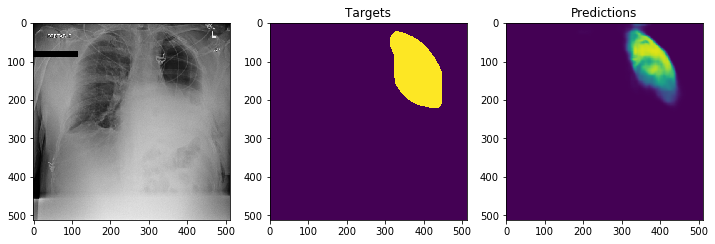

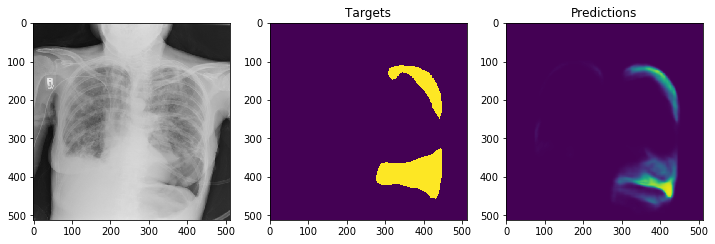

In [18]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]

#preds_m = (preds > 0.1).long()

for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

## submission


In [13]:
tag = '20190718-105908_512'

for fold in range(nfolds):
    print('fold: ', fold)
    
    data = get_data(fold)
    
    # load pretrained model
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.load('hc_{}_fold{}'.format(tag, fold))
    
    #prediction on val and test sets
    pt, _ = pred_with_flip(learn, DatasetType.Test)
    
    if fold == 0:
        ptt = pt
    else:
        ptt += pt


fold:  0


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  1


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  2


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  3


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
ptt /= nfolds

In [15]:
# save ptt

torch.save(ptt, 'hc_ptt_{}.pth'.format(tag))

In [14]:
# load ptt
tag = '20190718-105908_512'

ptt = torch.load('hc_ptt_{}.pth'.format(tag))

In [15]:
# majority vote - no we don't actually use vote

best_thr = 0.5525
print(best_thr)

pt_mask = (ptt[:,...]>best_thr).long()


0.5525


In [16]:
# noise removal

best_nthr = 10
print(best_nthr)

pt_clean = pt_mask.clone()
pt_clean[pt_clean.view(pt_clean.shape[0],-1).sum(-1) < best_nthr*(sz/128.0)**2,...] = 0.0


10


In [37]:
print(pt_mask.shape)
plt.imshow(pt_clean[15].T)
plt.colorbar()

torch.Size([1377, 512, 512])


AttributeError: 'Tensor' object has no attribute 'T'

In [17]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((1024, 1024))
    im = np.asarray(im)

    rle = mask2rle(im, 1024, 1024)
    
    return rle

pool = mp.Pool()
rle_list = pool.map(mask_worker, pt_clean.numpy())

In [18]:
ids = [o.stem for o in get_data(0).test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rle_list})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'

sub_df.to_csv('hc_sub.csv', index=False)

sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1


## classifier probe

In [23]:
date_tag = '0'

cls_rles = ['-1' if rle != '' else '1 2' for rle in rles]
cls_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': cls_rles})
cls_df.loc[cls_df.EncodedPixels=='', 'EncodedPixels'] = '1 2'
cls_df.to_csv('hc_{}_{}folds_cls.csv'.format(date_tag, nfolds), index=False)
cls_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,1 2
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,1 2
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,1 2
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,1 2
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,1 2
